In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import latools as la

from IPython.display import HTML

from comparison_tools import helpers, stats_1sample, plots_1sample

%matplotlib inline

## Data Collection Parameters


In [2]:
HTML(filename="./Parameter_Tables/iolite_data.html")

## Import Data

In [3]:
# define data format description so it can be imported by latools
dataformat = {'genfromtext_args': {'delimiter': ',',
                                   'skip_header': 15},
              'column_id': {'name_row': 13,
                            'delimiter': ',',
                            'timecolumn': 0,
                            'pattern': '([0-9]{1,3}[A-z]{1,2})'},
              'meta_regex': {0: (['name', 'date'],
                                 '([A-z0-9-]+):([0-9/ :AMP]+);')}
             }

In [4]:
dat = la.analyse('raw_data/iolite_data', internal_standard='43Ca', srm_identifier='NIST610',
                 dataformat=dataformat, names='metadata_names')

Loading Data:   5%|▍         | 11/225 [00:00<00:01, 107.76it/s]

Starting analysis using "UCD-AGILENT" configuration:


Loading Data: 100%|██████████| 225/225 [00:00<00:00, 314.09it/s]

  225 Data Files Loaded: 15 standards, 210 samples
  Analytes: 11B 24Mg 25Mg 27Al 43Ca 55Mn 57Fe 63Cu 66Zn 88Sr
  Internal Standard: 43Ca


In [5]:
sample = '1308H1-1e'

(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f7c41b67438>)

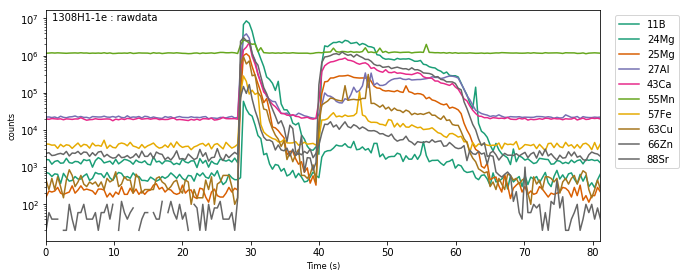

In [6]:
dat.data[sample].tplot()  # view raw data

## Data Processing

In [7]:
# despiking
dat.despike(noise_despiker=True, win=3)

Despiking: 100%|██████████| 225/225 [00:00<00:00, 1375.82it/s]


(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f7c416760b8>)

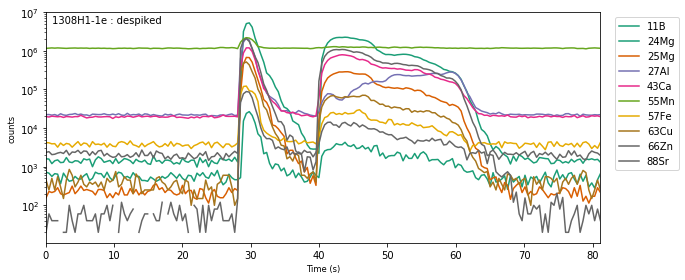

In [8]:
dat.data[sample].tplot()  # view despiked data

AutoRange: 100%|██████████| 225/225 [00:04<00:00, 58.09it/s]




*****************************************
                 WARNING
*****************************************
Autorange failed for some samples:
  1308H1-13c : 58.7
  1308H1-7a  : 59.5

*** THIS IS NOT NECESSARILY A PROBLEM ***
But please check the plots below to make
sure they look OK. Failures are marked by
dashed vertical red lines.

To examine an autorange failure in more
detail, use the `autorange_plot` method
of the failing data object, e.g.:
dat.data['Sample'].autorange_plot(params)
*****************************************



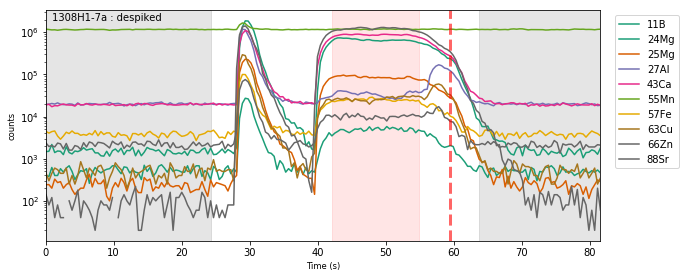

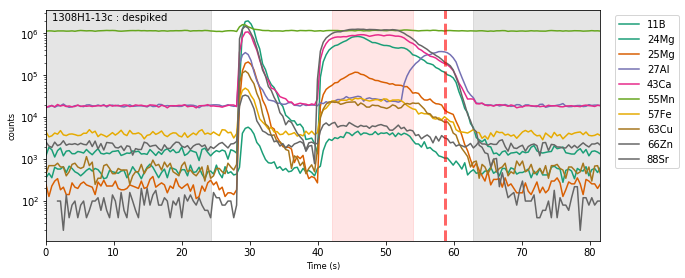

In [9]:
dat.autorange(on_mult=[3,.6], off_mult=[.5,3])

(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f7c403101d0>)

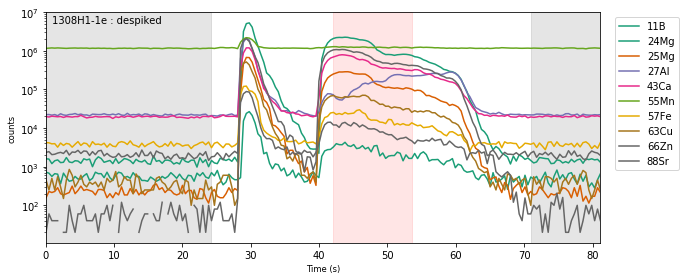

In [10]:
dat.data[sample].tplot(ranges=True)  # view autorange info

In [11]:
dat.bkg_calc_weightedmean(weight_fwhm=1000, bkg_filter=True)

Plotting backgrounds: 100%|██████████| 10/10 [00:15<00:00,  2.29s/it]


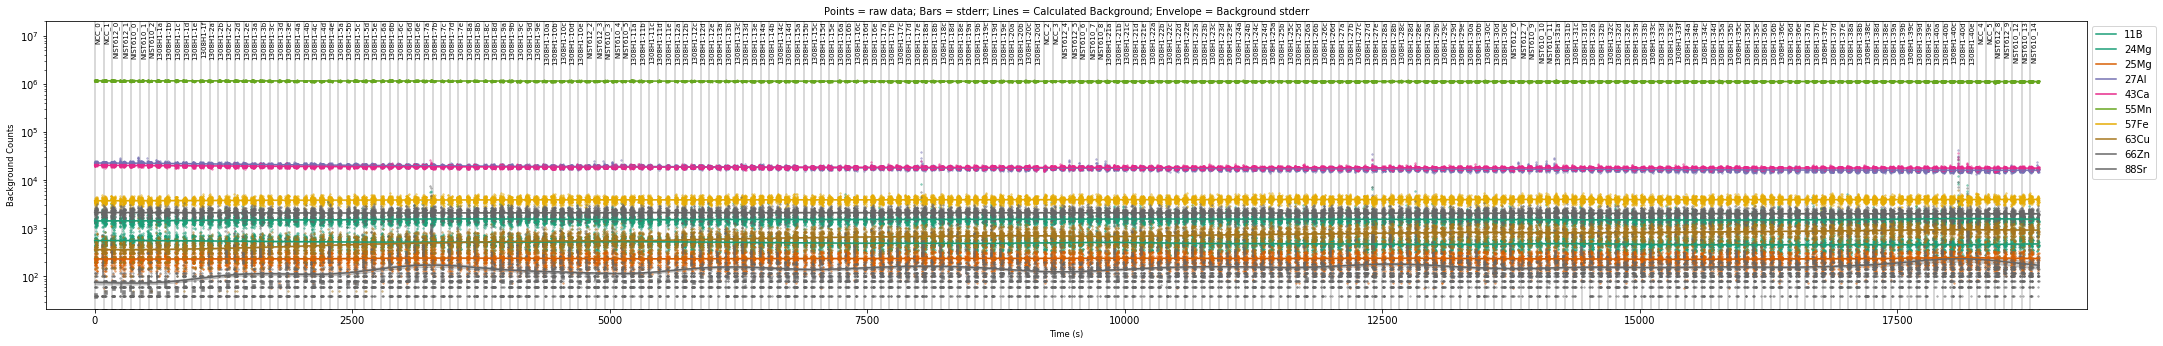

In [12]:
fig, ax = dat.bkg_plot()

In [13]:
dat.bkg_subtract()

Background Subtraction: 100%|██████████| 225/225 [00:06<00:00, 33.31it/s]


(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f7c2ced2c50>)

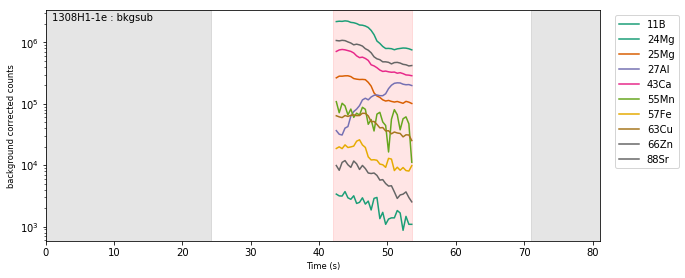

In [14]:
dat.data[sample].tplot(ranges=True)  # view background subtracted data

In [15]:
dat.ratio('43Ca')

Ratio Calculation: 100%|██████████| 225/225 [00:00<00:00, 265.28it/s]


(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f7c2a508be0>)

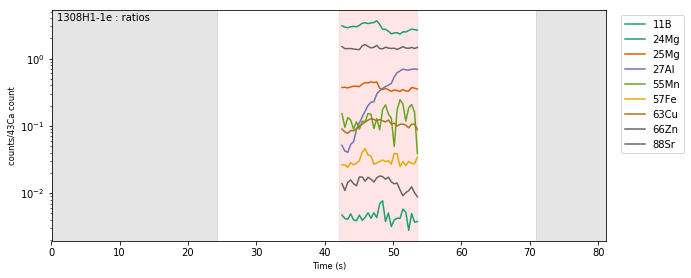

In [16]:
dat.data[sample].tplot(ranges=True)  # view ratio data

In [17]:
dat.calibrate(srms_used=['NIST610'])

Applying Calibrations: 100%|██████████| 225/225 [00:06<00:00, 32.88it/s]


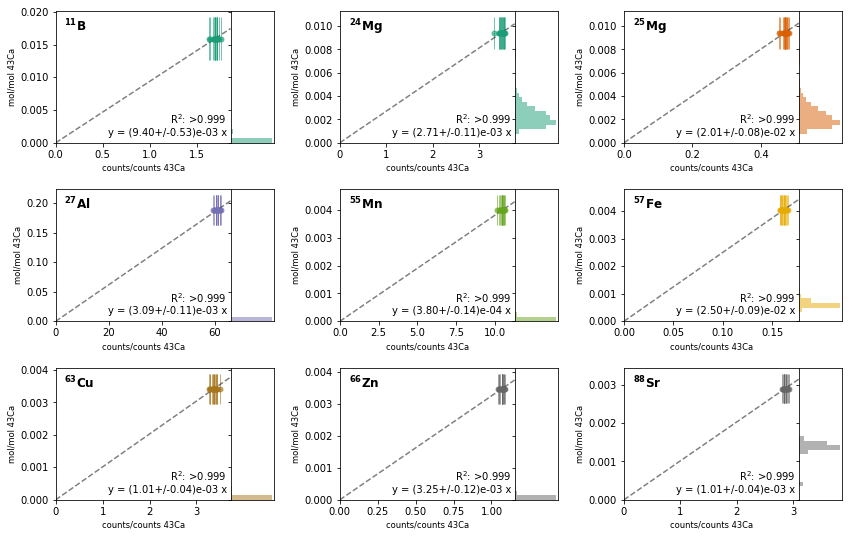

In [18]:
_ = dat.calibration_plot()

### Filtering

In [19]:
dat.filter_clear()

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 291.39it/s]


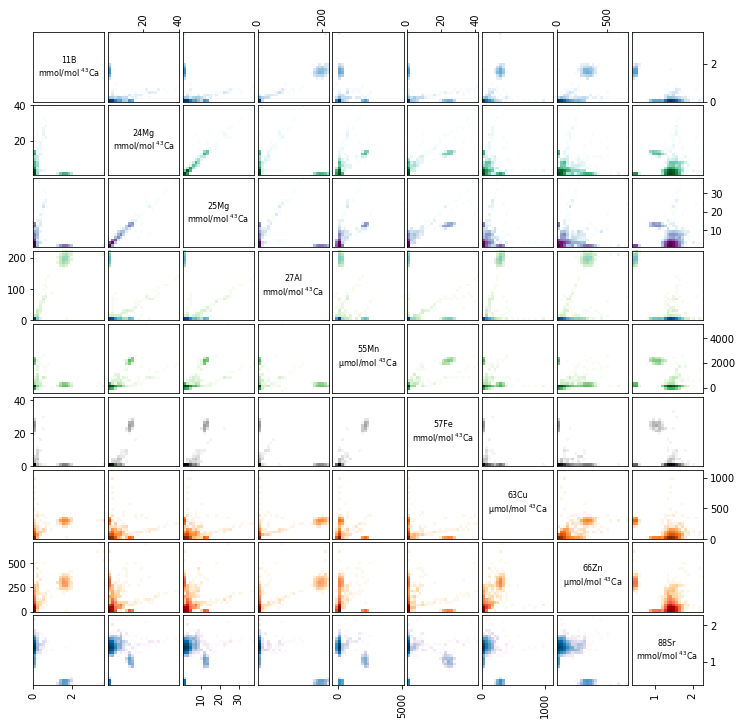

In [20]:
_ = dat.crossplot()

Crossplot shows two clear contaminant clusters:
1. Elevated Fe and Mn
2. Elevated Al and Zn

Both are likely clays, and can be removed with clustering filters.

In [21]:
dat.filter_clustering(['55Mn', '57Fe'], method='kmeans', n_clusters=2, level='population')

dat.filter_clustering(['27Al', '66Zn'], method='kmeans', n_clusters=2, level='population')

Applying 27Al_66Zn_kmeans classifier: 100%|██████████| 210/210 [00:00<00:00, 1148.71it/s]


In [22]:
dat.filter_on('_0', show_status=True)

Subset: All Samples

n  Filter Name           11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  55Mn_57Fe_kmeans_0    True   True   True   True   True   True   True   True   True   True   
1  55Mn_57Fe_kmeans_1    False  False  False  False  False  False  False  False  False  False  
2  27Al_66Zn_kmeans_0    True   True   True   True   True   True   True   True   True   True   
3  27Al_66Zn_kmeans_1    False  False  False  False  False  False  False  False  False  False  



Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 223.46it/s]


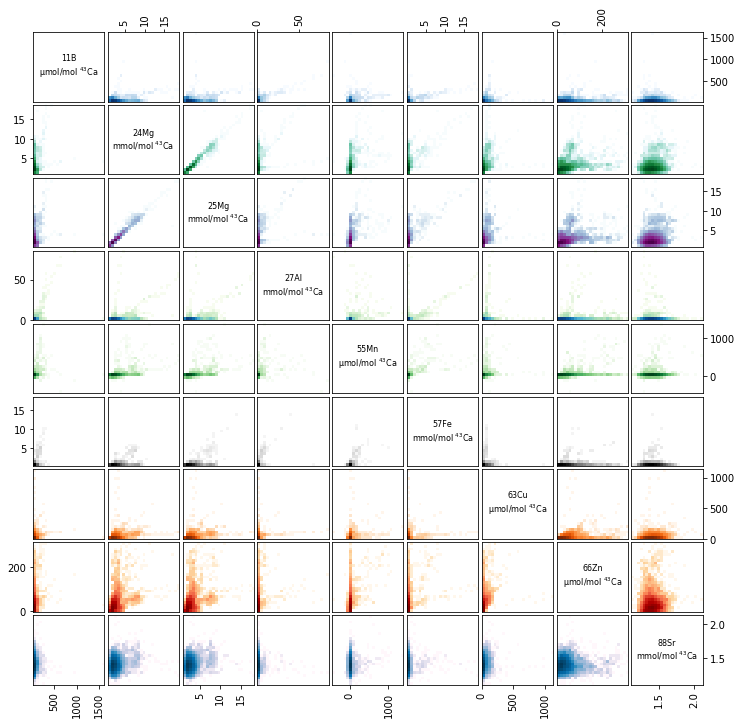

In [23]:
_ = dat.crossplot(filt=True)

There are still a lot of points elevated in Al, Mn, Fe and Zn, which tend to be associated with clay contaminants.

If associated with contaminants, they also likely have non-static signals. Let's have a look at the gradient crossplot for these elements.

Drawing Plots: 100%|██████████| 6/6 [00:00<00:00, 310.94it/s]


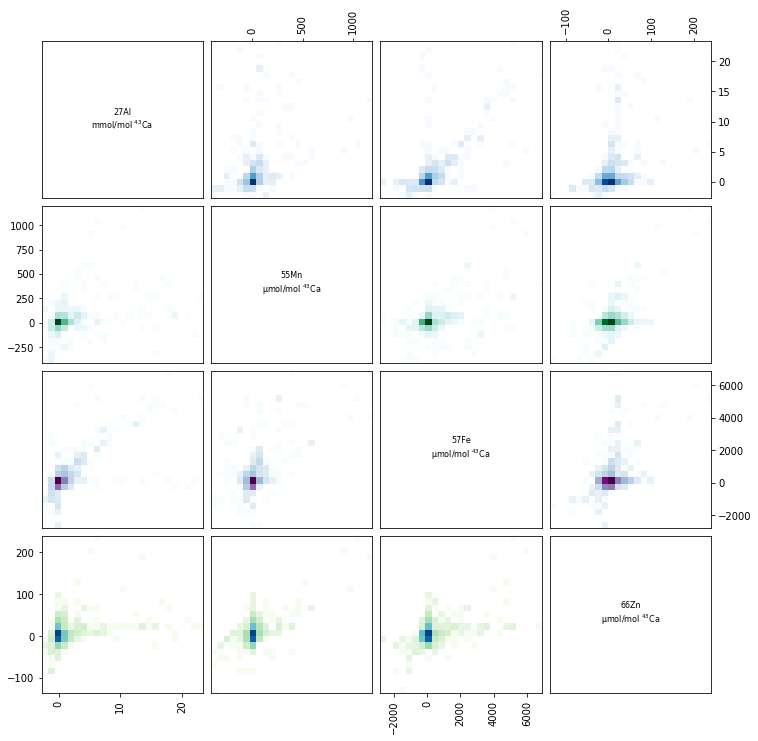

In [24]:
_ = dat.gradient_crossplot(['27Al', '55Mn', '57Fe', '66Zn'], win=5, filt=True)

Al and Fe seem to have some highly variable bits - remove the 5% most variable bits with a gradient threshold filter.

In [25]:
dat.filter_gradient_threshold_percentile('27Al', [2.5, 92.5], win=5, filt=True)

Percentile Threshold Filter: 100%|██████████| 210/210 [00:00<00:00, 233.22it/s]


In [26]:
dat.filter_gradient_threshold_percentile('57Fe', [2.5, 97.5], win=5, filt=True)

Percentile Threshold Filter: 100%|██████████| 210/210 [00:01<00:00, 197.63it/s]


In [27]:
dat.filter_gradient_threshold_percentile('66Zn', [2.5, 97.5], win=5, filt=True)

Percentile Threshold Filter: 100%|██████████| 210/210 [00:00<00:00, 233.11it/s]


In [28]:
# dat.filter_gradient_threshold_percentile('11B', [2.5, 97.5], win=5, filt=True)

In [29]:
dat.filter_on('27Al_2.5-95.0-grd-pcnt_inside')
dat.filter_on('57Fe_2.5-95.0-grd-pcnt_inside')
dat.filter_on('11B_2.5-97.5-grd-pcnt_inside', show_status=True)

Subset: All Samples

n  Filter Name                       11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  55Mn_57Fe_kmeans_0                True   True   True   True   True   True   True   True   True   True   
1  55Mn_57Fe_kmeans_1                False  False  False  False  False  False  False  False  False  False  
2  27Al_66Zn_kmeans_0                True   True   True   True   True   True   True   True   True   True   
3  27Al_66Zn_kmeans_1                False  False  False  False  False  False  False  False  False  False  
4  27Al_2.5-92.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
5  27Al_2.5-92.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
6  57Fe_2.5-97.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
7  57Fe_2.5-97.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
8  66Zn

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 47.97it/s]


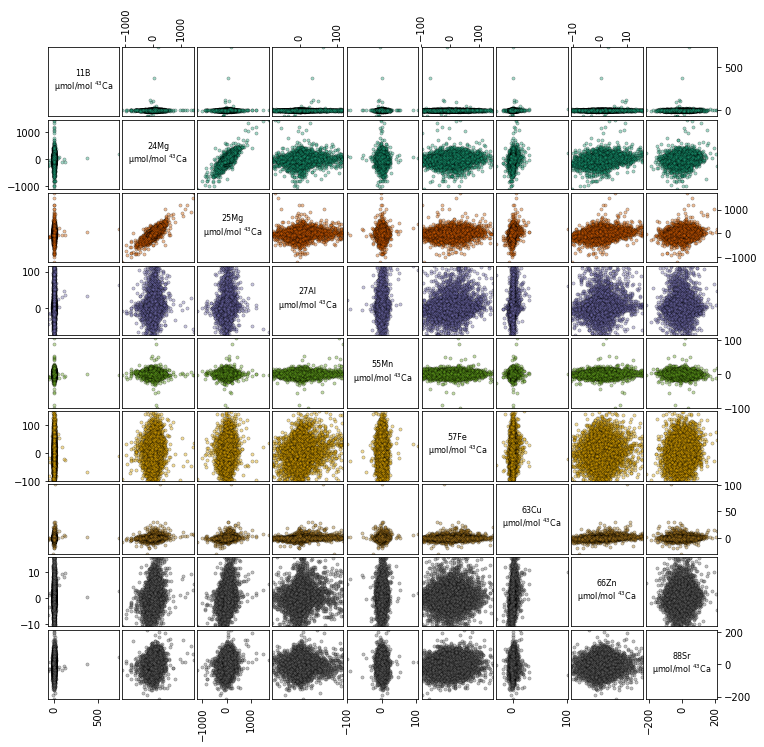

In [30]:
fig, axs = dat.gradient_crossplot(filt=True, mode='scatter', win=5)

Everything looks a lot cleaner now... what about the concentrations? 

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 48.80it/s]


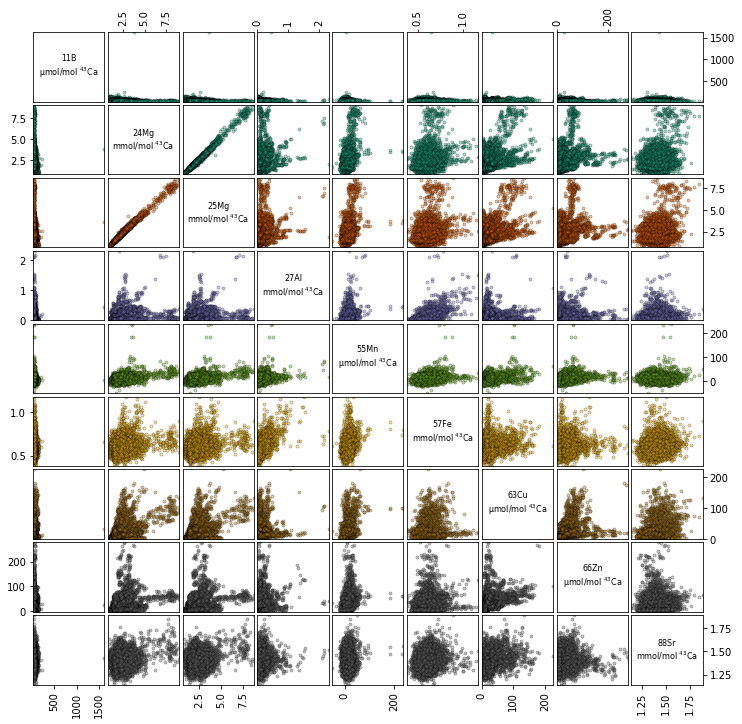

In [31]:
fig, axs = dat.crossplot(filt=True, mode='scatter')

There are a few wild outliers - remove them using concentration thresholds.

In [32]:
dat.filter_threshold('27Al', 0.5e-3)  # this will remove quite a few data points, but is a very high Al/Ca for forams
dat.filter_threshold('66Zn', 150e-6)  # | 
dat.filter_threshold('63Cu', 100e-6)  # | - to remove v high values
dat.filter_threshold('55Mn', 90e-6)   # |
dat.filter_threshold('11B', 500e-6)  # To remove a few flyers

Threshold Filter: 100%|██████████| 210/210 [00:00<00:00, 9495.92it/s]


In [33]:
dat.filter_on([10, 12, 14, 16, 18], show_status=True)

Subset: All Samples

n  Filter Name                       11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  55Mn_57Fe_kmeans_0                True   True   True   True   True   True   True   True   True   True   
1  55Mn_57Fe_kmeans_1                False  False  False  False  False  False  False  False  False  False  
2  27Al_66Zn_kmeans_0                True   True   True   True   True   True   True   True   True   True   
3  27Al_66Zn_kmeans_1                False  False  False  False  False  False  False  False  False  False  
4  27Al_2.5-92.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
5  27Al_2.5-92.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
6  57Fe_2.5-97.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
7  57Fe_2.5-97.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
8  66Zn

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 288.89it/s]


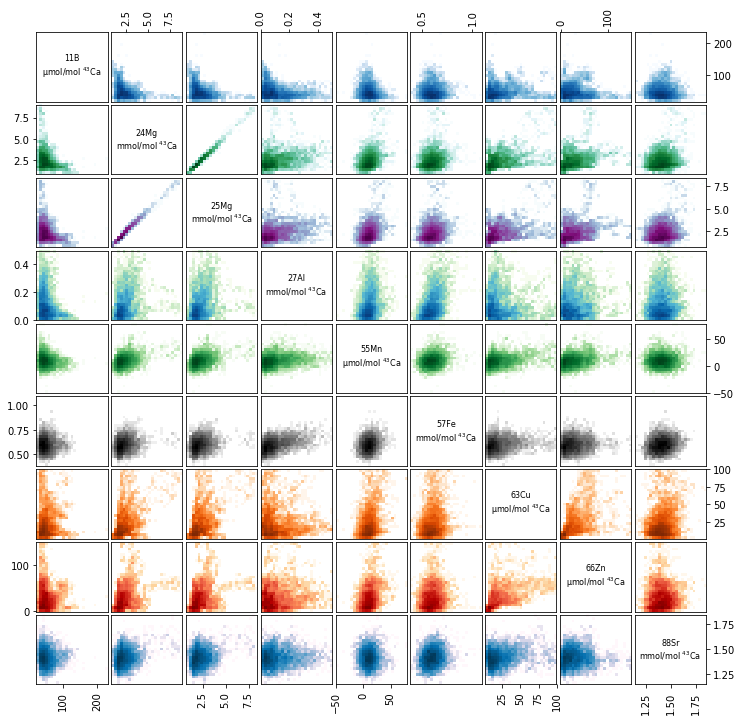

In [34]:
# a last look at the data
_ = dat.crossplot(filt=True)

In [35]:
# and should look at all the traces individualls
# dat.trace_plots(filt=True)

(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f7c087c8a90>)

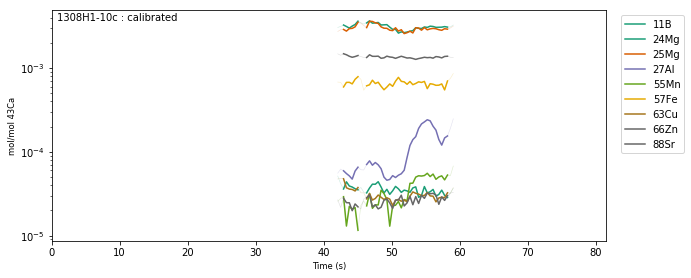

In [36]:
dat.data['1308H1-10c'].tplot(filt=True)  # view ratio data

In [37]:
dat.sample_stats(stats=['mean'])

Calculating Stats: 100%|██████████| 225/225 [00:27<00:00,  8.32it/s]


In [38]:
ld = dat.getstats() * 1e3

### Save minimal export

This produces a .zip file containing all the raw data, the SRM values you used, and a record of everything you did to the data.

the zip file can be opened with `latools.reproduce`, to recreate your entire analysis.

In [39]:
dat.minimal_export(path='raw_data/iolite_data_export/minimal_export.zip')

### Load Data

In [40]:
import re
import string

In [41]:
# ld = pd.read_csv('Cleaning test/RUN1_export/stat_export.csv', index_col=[0,1,2])
# ld *= 1e3  # convert to mmol/mol
ld = ld.loc['mean', :].dropna().reset_index()

# extract sample and replicate names
mtch = re.compile('([A-Z0-9]+)[_-]([0-9]+)([a-z]?)')\

for i, s in ld['sample'].iteritems():
    gs = mtch.match(s).groups()
    
    if gs[-1] == '':
        r = gs[1]
        s = gs[0]
    else:
        r = string.ascii_lowercase.index(gs[-1])
        s = gs[0] + '_' + gs[1]
    
    ld.loc[i, 'rep'] = r
    ld.loc[i, 'sample'] = s

ld.set_index(['sample', 'rep'], inplace=True)

In [42]:
rd = helpers.load_reference_data('iolite_reference')

In [43]:
df = rd.join(ld)

In [44]:
# no unique samples
np.unique(rd.index.levels[0]).size

89

## Characterise reproducibility in Reference data


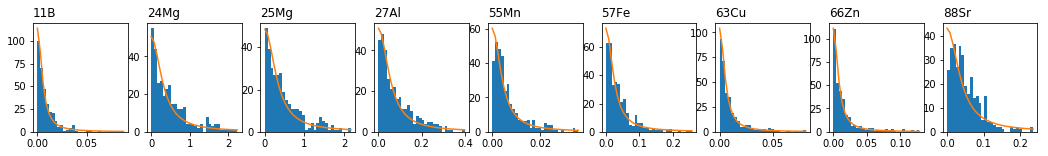

In [45]:
_ = stats_1sample.pairwise_reproducibility(ld, plot=True)

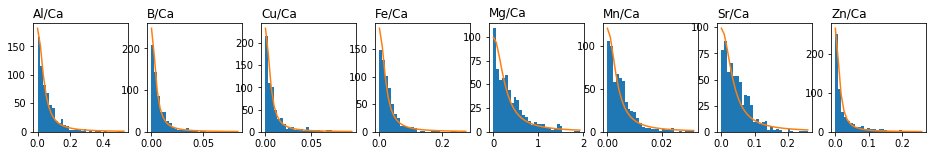

In [46]:
_, rep_dists, rep_stats, _ = stats_1sample.pairwise_reproducibility(rd, plot=True)

In [47]:
rep = pd.DataFrame(rep_stats).T
rep.columns = ['50%', '95%']
rep = rep.reindex(['Mg/Ca', 'Sr/Ca', 'Ba/Ca', 'Al/Ca', 'Mn/Ca', 'Cu/Ca', 'Fe/Ca', 'Zn/Ca', 'B/Ca'])

In [48]:
rep.to_csv('reproducibility_quants.csv')

### Compare

In [49]:
# _ = plots_1sample.comparison_plots(df)

In [50]:
# _ = plots_1sample.residual_plots(df)

In [51]:
from comparison_tools import plots_1sample

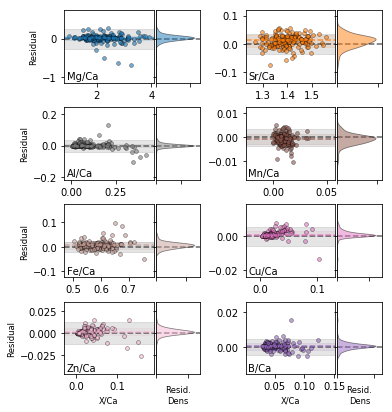

In [52]:
fig, axs = plots_1sample.bland_altman_plots(df, rep_stats)

In [53]:
fig.savefig('Figures/iolite_comparison.pdf')
fig.savefig('Figures/iolite_comparison.png', dpi=200)

## Summary Statistics

In [54]:
stat = stats_1sample.comparison_stats(df)

In [55]:
stat.to_csv('Stats/iolite_stats.csv')